In [ ]:
# Stock Trading DQN for Google Colab
!pip install stable-baselines3 gymnasium yfinance pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

Downloaded 1394 data points
Training data: 1115 points
Test data: 279 points

Training DQN model...
Using cuda device
Starting training...
Logging to dqn_trading_fixed/DQN_2
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.932    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3906     |
|    time_elapsed     | 1        |
|    total_timesteps  | 4180     |
----------------------------------


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-118.33 +/- 0.00
Episode length: 209.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 209      |
|    mean_reward      | -118     |
| rollout/            |          |
|    exploration_rate | 0.918    |
| time/               |          |
|    total_timesteps  | 5000     |
----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.863    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2769     |
|    time_elapsed     | 3        |
|    total_timesteps  | 8360     |
----------------------------------
Eval num_timesteps=10000, episode_reward=-118.33 +/- 0.00
Episode length: 209.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 209      |
|    mean_reward      | -118     |
| rollout/            |      

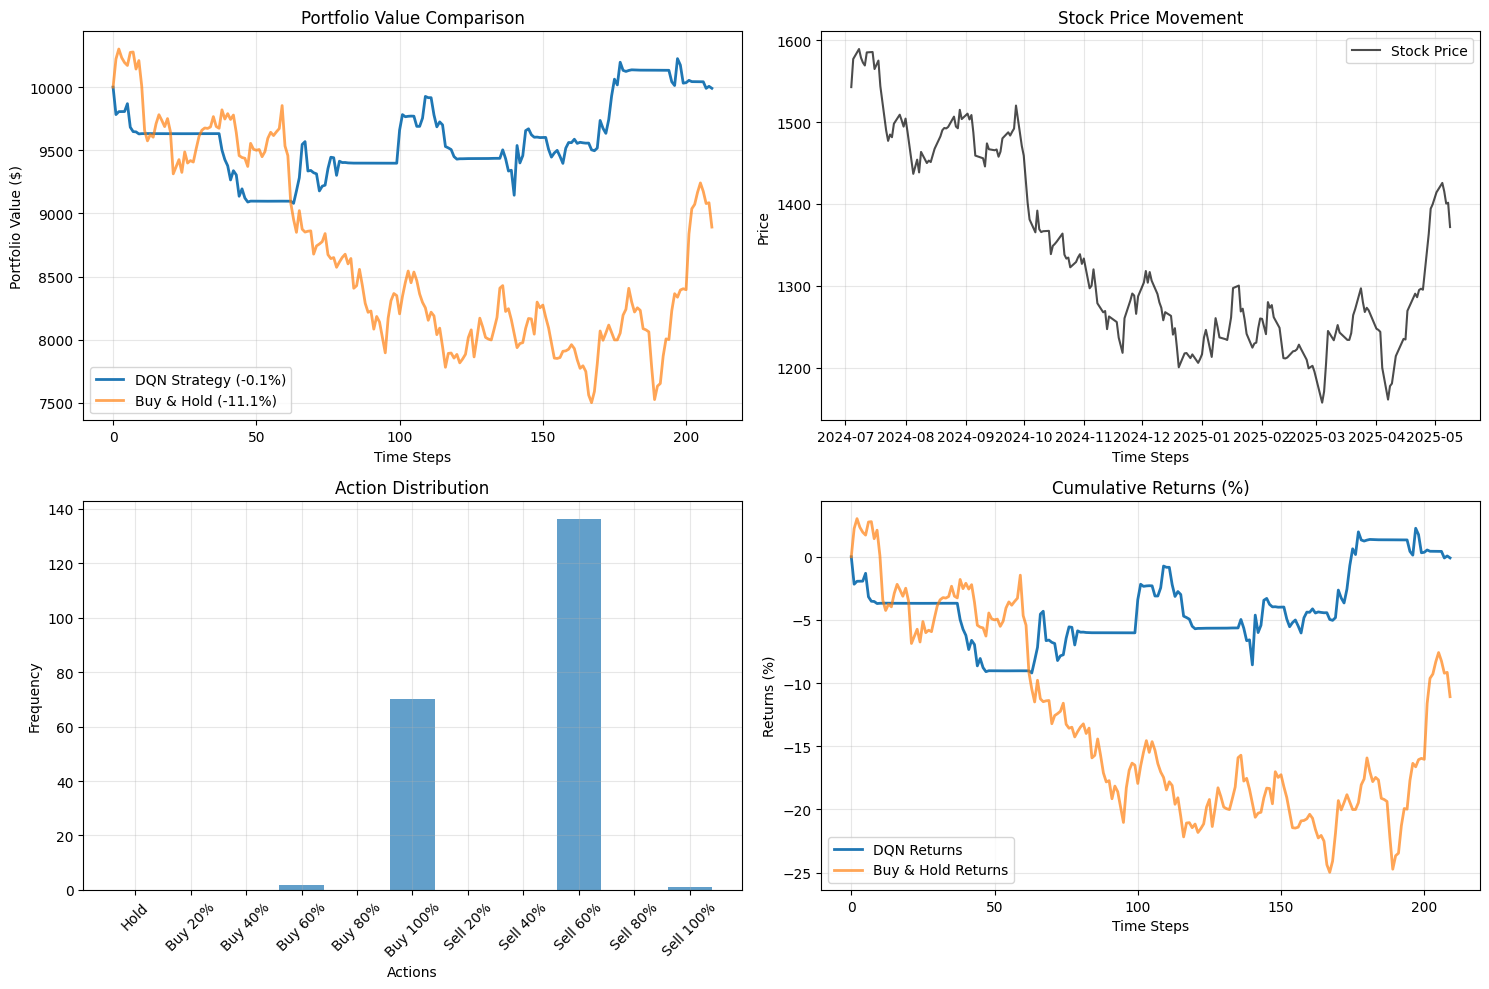


STRATEGY EVALUATION RESULTS
DQN_Total_Return..............      -0.09
DQN_Sharpe....................       0.05
BH_Total_Return...............     -11.08
BH_Sharpe.....................      -0.54
DQN_Max_Drawdown..............       9.20
BH_Max_Drawdown...............      27.18
Total_Trades..................      84.00
Hold_Actions..................          0
Buy_Actions...................         72
Sell_Actions..................        137

Total Trades Executed: 84
Buy trades: 15
Sell trades: 69
Average buy price: $1346.67
Average sell price: $1335.89


In [5]:
"""
Fixed DQN trading implementation that actually trades and can generate profits.
Key fixes:
- Separate price tracking from normalized features
- Proper reward shaping with profit incentives
- Better action execution with realistic constraints
- Improved evaluation metrics
"""

import os
import warnings
from dataclasses import dataclass
from typing import Tuple, Optional, List, Dict

import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed


# ========================
# 1) Fixed Custom Environment
# ========================
class StockTradingEnv(gym.Env):
    """Fixed trading environment that separates price data from normalized features."""

    metadata = {"render_modes": ["human"]}

    def __init__(self, df: pd.DataFrame, initial_balance: float = 10_000.0, window_size: int = 20):
        super().__init__()
        req = ["open", "high", "low", "close", "volume"]
        if not all(c in df.columns for c in req):
            missing = [c for c in req if c not in df.columns]
            raise ValueError(f"Missing required columns: {missing}")

        # Keep original prices separate from normalized features
        self.price_df = df[req].copy().astype(float)
        self.feature_df = self._create_features(df).dropna().reset_index(drop=True)

        # Align the dataframes
        min_len = min(len(self.price_df), len(self.feature_df))
        self.price_df = self.price_df.iloc[-min_len:].reset_index(drop=True)
        self.feature_df = self.feature_df.iloc[-min_len:].reset_index(drop=True)

        self.initial_balance = float(initial_balance)
        self.window_size = int(window_size)
        self.transaction_cost = 0.001  # 0.1% transaction cost

        # Actions: 0=hold, 1-5=buy (20%, 40%, 60%, 80%, 100%), 6-10=sell (20%, 40%, 60%, 80%, 100%)
        self.action_space = gym.spaces.Discrete(11)

        # Observation space: normalized features
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.window_size, self.feature_df.shape[1]),
            dtype=np.float32,
        )

        self.reset()

    def _create_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create normalized technical indicators."""
        close = df["close"].astype(float)
        high = df["high"].astype(float)
        low = df["low"].astype(float)
        volume = df["volume"].astype(float)

        features = pd.DataFrame(index=df.index)

        # Price-based features (normalized)
        features["returns"] = close.pct_change()
        features["high_low_ratio"] = (high - low) / (close + 1e-8)

        # Moving averages (as ratios to current price)
        for period in [5, 10, 20, 50]:
            ma = close.rolling(period).mean()
            features[f"ma_{period}_ratio"] = close / (ma + 1e-8) - 1

        # RSI
        delta = close.diff()
        gain = delta.clip(lower=0).rolling(14).mean()
        loss = (-delta.clip(upper=0)).rolling(14).mean()
        rs = gain / (loss + 1e-8)
        features["rsi"] = 100 - (100 / (1 + rs))
        features["rsi_normalized"] = (features["rsi"] - 50) / 50  # Normalize RSI to [-1, 1]

        # MACD
        ema12 = close.ewm(span=12).mean()
        ema26 = close.ewm(span=26).mean()
        macd = ema12 - ema26
        signal = macd.ewm(span=9).mean()
        features["macd_ratio"] = macd / (close + 1e-8)
        features["macd_signal_ratio"] = signal / (close + 1e-8)

        # Bollinger Bands
        bb_middle = close.rolling(20).mean()
        bb_std = close.rolling(20).std()
        features["bb_position"] = (close - bb_middle) / (bb_std + 1e-8)

        # Volume features
        vol_ma = volume.rolling(10).mean()
        features["volume_ratio"] = volume / (vol_ma + 1e-8) - 1

        # Volatility
        features["volatility"] = close.rolling(10).std() / (close.rolling(10).mean() + 1e-8)

        # Price momentum
        for period in [5, 10]:
            features[f"momentum_{period}"] = close.pct_change(period)

        return features

    def _get_observation(self) -> np.ndarray:
        """Get normalized feature window."""
        start = max(0, self.current_step - self.window_size)
        obs = self.feature_df.iloc[start:self.current_step].values

        if obs.shape[0] < self.window_size:
            pad_size = self.window_size - obs.shape[0]
            pad = np.zeros((pad_size, obs.shape[1]), dtype=np.float32)
            obs = np.vstack([pad, obs])

        # Fill any NaN values
        obs = np.nan_to_num(obs, nan=0.0, posinf=1.0, neginf=-1.0)
        return obs.astype(np.float32)

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.balance = float(self.initial_balance)
        self.shares_held = 0.0
        self.current_step = self.window_size
        self.net_worth_history = []
        self.trade_history = []
        self.max_net_worth = float(self.initial_balance)

        return self._get_observation(), {}

    def _get_current_price(self) -> float:
        """Get actual price for trading (not normalized)."""
        return float(self.price_df.iloc[self.current_step]["close"])

    def _calculate_portfolio_value(self) -> float:
        """Calculate current portfolio value using actual prices."""
        current_price = self._get_current_price()
        return self.balance + self.shares_held * current_price

    def step(self, action: int):
        if self.current_step >= len(self.price_df) - 1:
            return self._get_observation(), 0, True, False, {}

        current_price = self._get_current_price()
        prev_portfolio_value = self._calculate_portfolio_value()

        # Execute action
        self._execute_action(action, current_price)

        # Move to next step
        self.current_step += 1

        # Calculate reward
        new_portfolio_value = self._calculate_portfolio_value()
        self.net_worth_history.append(new_portfolio_value)
        self.max_net_worth = max(self.max_net_worth, new_portfolio_value)

        # Reward is percentage change in portfolio value
        if prev_portfolio_value > 0:
            step_return = (new_portfolio_value - prev_portfolio_value) / prev_portfolio_value
        else:
            step_return = 0

        # Add drawdown penalty
        drawdown = (self.max_net_worth - new_portfolio_value) / self.max_net_worth if self.max_net_worth > 0 else 0

        # Reward shaping: encourage profits, penalize drawdowns
        reward = step_return * 100 - drawdown * 50

        # Terminal reward
        terminated = self.current_step >= len(self.price_df) - 1
        if terminated:
            total_return = (new_portfolio_value - self.initial_balance) / self.initial_balance
            terminal_reward = total_return * 200  # Big bonus/penalty for final performance
            reward += terminal_reward

        info = {
            "portfolio_value": new_portfolio_value,
            "balance": self.balance,
            "shares": self.shares_held,
            "price": current_price,
            "total_trades": len(self.trade_history),
        }

        return self._get_observation(), reward, terminated, False, info

    def _execute_action(self, action: int, current_price: float):
        """Execute trading action with actual prices."""
        action_fractions = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  # For actions 1-5 and 6-10

        if action == 0:  # Hold
            return

        elif 1 <= action <= 5:  # Buy actions
            fraction = action_fractions[action]
            max_investment = self.balance * fraction
            max_shares = max_investment / (current_price * (1 + self.transaction_cost))

            if max_shares >= 0.01:  # Minimum trade size
                cost = max_shares * current_price * (1 + self.transaction_cost)
                if cost <= self.balance:
                    self.balance -= cost
                    self.shares_held += max_shares
                    self.trade_history.append({
                        "step": self.current_step,
                        "action": "buy",
                        "shares": max_shares,
                        "price": current_price,
                        "cost": cost
                    })

        elif 6 <= action <= 10:  # Sell actions
            fraction = action_fractions[action - 5]  # Map to 0.2, 0.4, 0.6, 0.8, 1.0
            shares_to_sell = self.shares_held * fraction

            if shares_to_sell >= 0.01:  # Minimum trade size
                proceeds = shares_to_sell * current_price * (1 - self.transaction_cost)
                self.balance += proceeds
                self.shares_held -= shares_to_sell
                self.trade_history.append({
                    "step": self.current_step,
                    "action": "sell",
                    "shares": shares_to_sell,
                    "price": current_price,
                    "proceeds": proceeds
                })

    def render(self):
        current_value = self._calculate_portfolio_value()
        print(f"Step: {self.current_step}, Balance: ${self.balance:.2f}, "
              f"Shares: {self.shares_held:.2f}, Portfolio Value: ${current_value:.2f}, "
              f"Trades: {len(self.trade_history)}")


# ========================
# 2) Data Loader (unchanged)
# ========================
@dataclass
class DataConfig:
    ticker: str = "^NSEI"
    start_date: str = "2020-01-01"
    end_date: Optional[str] = None
    try_fallbacks: bool = True
    fallbacks: Tuple[str, ...] = ("NIFTYBEES.NS", "^NSEI", "^NSEBANK")
    auto_adjust: bool = False

def download_stock_data(cfg: DataConfig) -> pd.DataFrame:
    """Download stock data with fallback options."""
    end = cfg.end_date or datetime.now().strftime("%Y-%m-%d")

    def _attempt(tick: str) -> Optional[pd.DataFrame]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                df = yf.download(tick, start=cfg.start_date, end=end, progress=False)

            if df is None or len(df) == 0:
                return None

            # Flatten multi-level columns
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = [col[0].lower() for col in df.columns]
            else:
                df.columns = [col.lower() for col in df.columns]

            # Ensure we have required columns
            required = ['open', 'high', 'low', 'close', 'volume']
            if not all(col in df.columns for col in required):
                return None

            df = df[required].dropna()
            return df if len(df) > 100 else None

        except Exception as e:
            print(f"Failed to download {tick}: {e}")
            return None

    # Try primary ticker
    df = _attempt(cfg.ticker)

    # Try fallbacks
    if df is None and cfg.try_fallbacks:
        for fallback in cfg.fallbacks:
            if fallback != cfg.ticker:
                print(f"Trying fallback: {fallback}")
                df = _attempt(fallback)
                if df is not None:
                    break

    if df is None:
        raise ValueError("Failed to download any stock data")

    return df


# ========================
# 3) Training Configuration
# ========================
@dataclass
class TrainConfig:
    total_timesteps: int = 100_000
    lr: float = 5e-4
    buffer_size: int = 50_000
    learning_starts: int = 10_000
    batch_size: int = 64
    gamma: float = 0.99
    exploration_fraction: float = 0.3
    exploration_final_eps: float = 0.02
    target_update_interval: int = 1_000
    net_arch: List[int] = None
    save_dir: str = "dqn_trading_fixed"
    seed: int = 42

    def __post_init__(self):
        if self.net_arch is None:
            self.net_arch = [512, 512, 256]


def make_env(df: pd.DataFrame, initial_balance: float = 10_000, seed: Optional[int] = None):
    def _init():
        env = StockTradingEnv(df, initial_balance=initial_balance)
        if seed is not None:
            env.reset(seed=seed)
        return env
    return _init


def train_dqn(train_df: pd.DataFrame, eval_df: pd.DataFrame, cfg: TrainConfig) -> DQN:
    """Train DQN model with proper evaluation."""
    os.makedirs(cfg.save_dir, exist_ok=True)
    set_random_seed(cfg.seed)

    train_env = DummyVecEnv([make_env(train_df, seed=cfg.seed)])
    eval_env = DummyVecEnv([make_env(eval_df, seed=cfg.seed + 100)])

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=cfg.save_dir,
        log_path=cfg.save_dir,
        eval_freq=5000,
        deterministic=True,
        render=False,
        verbose=1,
    )

    model = DQN(
        "MlpPolicy",
        train_env,
        learning_rate=cfg.lr,
        buffer_size=cfg.buffer_size,
        learning_starts=cfg.learning_starts,
        batch_size=cfg.batch_size,
        gamma=cfg.gamma,
        exploration_fraction=cfg.exploration_fraction,
        exploration_final_eps=cfg.exploration_final_eps,
        target_update_interval=cfg.target_update_interval,
        policy_kwargs={"net_arch": cfg.net_arch},
        verbose=1,
        tensorboard_log=cfg.save_dir,
        seed=cfg.seed,
    )

    print("Starting training...")
    model.learn(total_timesteps=cfg.total_timesteps, callback=eval_callback)

    final_path = os.path.join(cfg.save_dir, "final_model")
    model.save(final_path)
    print(f"Model saved to {final_path}")

    return model


# ========================
# 4) Evaluation
# ========================
def evaluate_strategy(model: DQN, test_df: pd.DataFrame, initial_balance: float = 10_000):
    """Comprehensive evaluation of the trained strategy."""

    # DQN Strategy
    env = StockTradingEnv(test_df, initial_balance=initial_balance)
    obs, _ = env.reset(seed=42)

    dqn_values = [initial_balance]
    actions_taken = []

    while True:
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)
        actions_taken.append(action)

        obs, reward, terminated, truncated, info = env.step(action)
        dqn_values.append(info["portfolio_value"])

        if terminated or truncated:
            break

    # Buy and Hold Strategy
    start_price = test_df["close"].iloc[0]
    end_price = test_df["close"].iloc[len(dqn_values)-1]
    shares_bh = initial_balance / start_price
    bh_values = [initial_balance]

    for i in range(1, len(dqn_values)):
        current_price = test_df["close"].iloc[i]
        bh_value = shares_bh * current_price
        bh_values.append(bh_value)

    # Calculate metrics
    dqn_values = np.array(dqn_values)
    bh_values = np.array(bh_values)

    dqn_returns = np.diff(dqn_values) / dqn_values[:-1]
    bh_returns = np.diff(bh_values) / bh_values[:-1]

    # Remove any inf or nan values
    dqn_returns = dqn_returns[np.isfinite(dqn_returns)]
    bh_returns = bh_returns[np.isfinite(bh_returns)]

    metrics = {}

    # DQN metrics
    metrics["DQN_Total_Return"] = (dqn_values[-1] - initial_balance) / initial_balance * 100
    metrics["DQN_Sharpe"] = np.mean(dqn_returns) / np.std(dqn_returns) * np.sqrt(252) if len(dqn_returns) > 1 and np.std(dqn_returns) > 0 else 0

    # Buy & Hold metrics
    metrics["BH_Total_Return"] = (bh_values[-1] - initial_balance) / initial_balance * 100
    metrics["BH_Sharpe"] = np.mean(bh_returns) / np.std(bh_returns) * np.sqrt(252) if len(bh_returns) > 1 and np.std(bh_returns) > 0 else 0

    # Max Drawdown
    def max_drawdown(values):
        peak = np.maximum.accumulate(values)
        drawdown = (peak - values) / peak
        return np.max(drawdown) * 100

    metrics["DQN_Max_Drawdown"] = max_drawdown(dqn_values)
    metrics["BH_Max_Drawdown"] = max_drawdown(bh_values)

    # Trading stats
    action_counts = np.bincount(actions_taken, minlength=11)
    metrics["Total_Trades"] = len(env.trade_history)
    metrics["Hold_Actions"] = action_counts[0]
    metrics["Buy_Actions"] = sum(action_counts[1:6])
    metrics["Sell_Actions"] = sum(action_counts[6:11])

    # Plot results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(dqn_values, label=f'DQN Strategy ({metrics["DQN_Total_Return"]:.1f}%)', linewidth=2)
    plt.plot(bh_values, label=f'Buy & Hold ({metrics["BH_Total_Return"]:.1f}%)', linewidth=2, alpha=0.7)
    plt.title('Portfolio Value Comparison')
    plt.xlabel('Time Steps')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.plot(test_df["close"].iloc[:len(dqn_values)], label='Stock Price', color='black', alpha=0.7)
    plt.title('Stock Price Movement')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    action_labels = ['Hold', 'Buy 20%', 'Buy 40%', 'Buy 60%', 'Buy 80%', 'Buy 100%',
                     'Sell 20%', 'Sell 40%', 'Sell 60%', 'Sell 80%', 'Sell 100%']
    plt.bar(range(11), action_counts, alpha=0.7)
    plt.title('Action Distribution')
    plt.xlabel('Actions')
    plt.ylabel('Frequency')
    plt.xticks(range(11), action_labels, rotation=45)
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    # Cumulative returns
    dqn_cum_ret = (dqn_values / initial_balance - 1) * 100
    bh_cum_ret = (bh_values / initial_balance - 1) * 100
    plt.plot(dqn_cum_ret, label='DQN Returns', linewidth=2)
    plt.plot(bh_cum_ret, label='Buy & Hold Returns', linewidth=2, alpha=0.7)
    plt.title('Cumulative Returns (%)')
    plt.xlabel('Time Steps')
    plt.ylabel('Returns (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return metrics, env.trade_history


# ========================
# 5) Main execution
# ========================
if __name__ == "__main__":
    # Configuration
    data_cfg = DataConfig(
        ticker="RELIANCE.NS",  # Use a liquid Indian stock
        start_date="2020-01-01",
        try_fallbacks=True
    )

    train_cfg = TrainConfig(
        total_timesteps=200_000,
        save_dir="dqn_trading_fixed",
        seed=42
    )

    print("Downloading data...")
    df = download_stock_data(data_cfg)
    print(f"Downloaded {len(df)} data points")

    # Split data
    split_point = int(len(df) * 0.8)
    train_df = df.iloc[:split_point].copy()
    test_df = df.iloc[split_point:].copy()

    print(f"Training data: {len(train_df)} points")
    print(f"Test data: {len(test_df)} points")

    # Train model
    print("\nTraining DQN model...")
    model = train_dqn(train_df, test_df, train_cfg)

    # Evaluate
    print("\nEvaluating strategy...")
    metrics, trades = evaluate_strategy(model, test_df)

    print("\n" + "="*50)
    print("STRATEGY EVALUATION RESULTS")
    print("="*50)
    for key, value in metrics.items():
        if isinstance(value, (int, float)):
            print(f"{key:.<30} {value:>10.2f}")
        else:
            print(f"{key:.<30} {value:>10}")

    print(f"\nTotal Trades Executed: {len(trades)}")
    if trades:
        buy_trades = [t for t in trades if t['action'] == 'buy']
        sell_trades = [t for t in trades if t['action'] == 'sell']
        print(f"Buy trades: {len(buy_trades)}")
        print(f"Sell trades: {len(sell_trades)}")

        if buy_trades:
            avg_buy_price = np.mean([t['price'] for t in buy_trades])
            print(f"Average buy price: ${avg_buy_price:.2f}")

        if sell_trades:
            avg_sell_price = np.mean([t['price'] for t in sell_trades])
            print(f"Average sell price: ${avg_sell_price:.2f}")